In [2]:
import tqdm.notebook as tqdm
import IPython.display as display
import json
import pickle
import glob
import os
#import open_clip
import torch
from PIL import Image
import numpy as np
from collections import defaultdict

In [1]:
from PIL import Image
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b", load_in_8bit=True, device_map={"": 0}, torch_dtype=torch.float16
)  # doctest: +IGNORE_RESULT

url = "http://images.cocodataset.org/val2017/000000039769.jpg"


c:\Python38\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

NameError: name 'glob' is not defined

In [2]:
import glob
image = Image.open(glob.glob('val2014/val2014/*')[0])

In [3]:
print(glob.glob('val2014/val2014/*')[0])

val2014/val2014\COCO_val2014_000000000042.jpg


In [9]:
import json
annotations = json.load(open('annotations_trainval2014/annotations/captions_val2014.json'))

391895

In [11]:
for annotation in json.load(open('annotations_trainval2014/annotations/captions_val2014.json'))['annotations']:
    if annotation['image_id'] == 391895:
        print(annotation['caption'])

A man with a red helmet on a small moped on a dirt road. 
Man riding a motor bike on a dirt road on the countryside.
A man riding on the back of a motorcycle.
A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. 
A man in a red shirt and a red hat is on a motorcycle on a hill side.


In [4]:
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

c:\Python38\lib\site-packages\transformers\generation\utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a dog is sleeping in a basket of shoes


In [9]:
inputs = processor(images=image, text='', return_tensors="pt").to(device, torch.float16)

outputs = model(**inputs)

In [13]:
[257][1408]

256

In [ ]:
concat ([0][1408], text) -> 1408

In [ ]:
text = text + embedding(score)

In [11]:
outputs.vision_outputs[0].shape

torch.Size([1, 257, 1408])

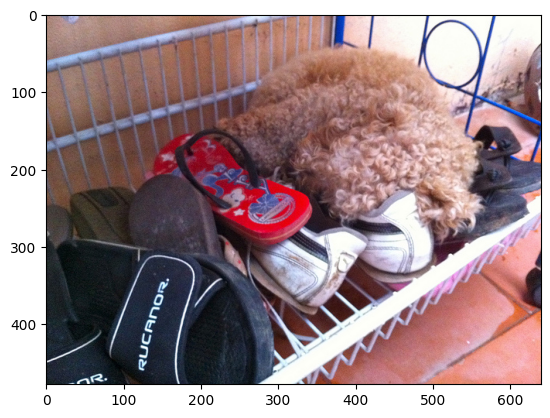

In [5]:
import matplotlib.pyplot as plt
plt.imshow(image)

In [4]:
for param in model.vision_model.parameters():
    if type(param) == torch.nn.parameter.Parameter:
        #print(param.shape, param.requires_grad)
        param.requires_grad = False

In [5]:
for param in model.language_model.parameters():
    param.requires_grad = False

In [6]:
model.qformer.train()

Blip2QFormerModel(
  (layernorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (encoder): Blip2QFormerEncoder(
    (layer): ModuleList(
      (0): Blip2QFormerLayer(
        (attention): Blip2QFormerAttention(
          (attention): Blip2QFormerMultiHeadAttention(
            (query): Linear8bitLt(in_features=768, out_features=768, bias=True)
            (key): Linear8bitLt(in_features=768, out_features=768, bias=True)
            (value): Linear8bitLt(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): Blip2QFormerSelfOutput(
            (dense): Linear8bitLt(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (crossattention): Blip2QFormerAttention(
          (attention): Blip2QFormerMultiHeadAttenti

In [8]:
#get number of trainable params in model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 72,192 trainable parameters


In [17]:
from peft import LoftQConfig, LoraConfig, get_peft_model

loftq_config = LoftQConfig(loftq_bits=4)           # set 4bit quantization
lora_config = LoraConfig(init_lora_weights="loftq", loftq_config=loftq_config)
peft_model = get_peft_model(model, lora_config)

In [25]:
print(f'The model has {count_parameters(peft_model):,} trainable parameters')

The model has 2,621,440 trainable parameters


In [3]:
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn
import numpy as np
import pickle

In [43]:
class TrainDataset(Dataset):
    def __init__(self, k = 1, path='', knn_file = 'data_max/kNN.npy', dict_file ='data_max/dictionaries/image_name.pickle', image_2_cap = 'data_max/dictionaries/image_name_2_captions.pickle'):

        self.root = path
        self.kNN = np.load(self.root + knn_file, allow_pickle=True)

        with open(self.root + dict_file, 'rb') as handle:
            self.max_caption_dict = pickle.load(handle)

        with open(self.root + image_2_cap, 'rb') as handle:
            self.image_caption_dict = pickle.load(handle)

        self.img_names = sorted(list(self.max_caption_dict.keys()))

        self.img_names = [name.split('/')[1].split('.')[0] for name in self.img_names]

        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")

    def __getitem__(self, idx):
        #img embedding, caption embedding, kNN scores, kNN indices

        img_name = self.img_names[idx]
        image = Image.open(self.root + 'train2014/train2014/' + img_name + '.jpg')

        scores, indices = self.kNN[idx]

        max_caption = self.image_caption_dict[self.img_names[int(indices[0])] + '.jpg'][self.max_caption_dict['train_emb/'+self.img_names[int(indices[0])]+'.npy']]

        inputs = self.processor(images=image, text=max_caption + ' Rephrase',return_tensors="pt",  padding='max_length', truncation=True, max_length = 20).to(self.device, torch.float16)

        caption = self.image_caption_dict[img_name + '.jpg'][self.max_caption_dict['train_emb/'+ img_name + '.npy']]

        caption_ids = self.processor.tokenizer(text = caption, return_tensors="pt", padding='max_length', truncation=True, max_length = 20).input_ids.to(self.device)

        #inputs.input_ids, inputs.pixel_values = inputs.input_ids.to(self.device).squeeze(0), inputs.pixel_values.to(self.device).squeeze(0)
        
        return inputs.input_ids.to(self.device).squeeze(0), inputs.pixel_values.to(self.device).squeeze(0), inputs.attention_mask.to(self.device).squeeze(0), caption_ids.to(self.device).squeeze(0)

    def __len__(self):
        return len(self.img_names)

In [44]:
class TrainDataset_(Dataset):
    def __init__(self, k = 1, path='/3d_data/datasets/coco/', knn_file = 'knn/kNN.npy', dict_file ='image_name.pickle', image_2_cap = 'image_name_2_captions.pickle'):

        self.root = path
        self.kNN = np.load(self.root + knn_file, allow_pickle=True)

        with open(self.root + dict_file, 'rb') as handle:
            self.max_caption_dict = pickle.load(handle)

        with open(self.root + image_2_cap, 'rb') as handle:
            self.image_caption_dict = pickle.load(handle)

        self.img_names = sorted(list(self.max_caption_dict.keys()))

        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.img_names = [name.split('/')[1].split('.')[0] for name in self.img_names]

        self.processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")

    def __getitem__(self, idx):
        #img embedding, caption embedding, kNN scores, kNN indices

        img_name = self.img_names[idx]
        image = Image.open(self.root + 'train2014/' + img_name + '.jpg')

        scores, indices = self.kNN[idx]
        
        max_caption = self.image_caption_dict[self.img_names[int(indices[0])] + '.jpg'][self.max_caption_dict['train_emb/'+self.img_names[int(indices[0])]+'.npy']]

        inputs = self.processor(images=image, text=max_caption + ' Rephrase',return_tensors="pt",  padding='max_length', truncation=True, max_length = 20).to(self.device, torch.float16)

        caption = self.image_caption_dict[img_name + '.jpg'][self.max_caption_dict['train_emb/'+ img_name + '.npy']]

        caption_ids = self.processor.tokenizer(text = caption, return_tensors="pt", padding='max_length', truncation=True, max_length = 20).input_ids.to(self.device)

        return inputs.input_ids.to(self.device).squeeze(0), inputs.pixel_values.to(self.device).squeeze(0), inputs.attention_mask.to(self.device).squeeze(0), caption_ids.to(self.device).squeeze(0)

    def __len__(self):
        return len(self.img_names)

In [45]:
dataset = TrainDataset()
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

c:\Python38\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b", load_in_8bit=True, device_map={"": 0}, torch_dtype=torch.float16
) 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [47]:

for param in model.language_model.parameters():
    param.requires_grad = False

for param in model.vision_model.parameters():
    if type(param) == torch.nn.parameter.Parameter:
        param.requires_grad = False

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.0001)

In [49]:
save_path = '/3d_data/retreiver/base/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

NameError: name 'os' is not defined

In [50]:
model.train()

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear8bitLt(in_features=1408, out_features=4224, bias=True)
            (projection): Linear8bitLt(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear8bitLt(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear8bitLt(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post

In [53]:
best_loss = 1000
for epoch in range(100):
    for i, (input_ids, pixel_values, attenion_masks, caption_ids) in enumerate(dataloader):
        optimizer.zero_grad()

        outputs = model(pixel_values = pixel_values, input_ids = input_ids, attention_mask = attenion_masks, labels=caption_ids)
        loss = outputs.loss
        
        loss.backward()
        optimizer.step()
        scheduler.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), save_path + 'best_model.pt')

    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')


RuntimeError: Parent directory /3d_data/retreiver/base does not exist.

In [4]:
image_path = glob.glob("train2014/*")[1]
image_path

['train2014\\train2014']

In [ ]:
caption_path = '/content/annotations/captions_train2014.json'
f = open(caption_path)
data = json.load(f)

In [ ]:
dict_filename = {}
for image in data['images']:
  dict_filename[image['id']] = image['file_name']

In [ ]:
dict_caption = defaultdict(list)
for caption in tqdm.tqdm(data['annotations']):
  dict_caption[dict_filename[caption['image_id']]].append(caption['caption'])

  0%|          | 0/414113 [00:00<?, ?it/s]

In [ ]:
with open('image_name_2_captions.pickle', 'wb') as handle:
    pickle.dump(dict_caption, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp image_name_2_captions.pickle drive/MyDrive/ECE285/image_name_2_captions.pickle

# Preparing Embeddings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Check if the file exists and is not empty
if os.path.exists("image_name_2_captions.pickle") and os.path.getsize("image_name_2_captions.pickle") > 0:
    with open("image_name_2_captions.pickle", mode='rb') as input_file:
        dict_caption = pickle.load(input_file)
else:
    print("The file is empty. Skipping loading data.")

In [6]:
dict_caption['COCO_train2014_000000282069.jpg']

['A black-and-white photo of a baseball team together.',
 'A baseball team by the name of "proctor" on the uniform, seated for a team photo.',
 'Black and white photo of a baseball team.',
 'A team of baseball players are posing for a group picture.',
 'A baseball team sitting next to each other in a pyramid holding bats.']

In [7]:
model, _, transform = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)

model = model.cuda()
tokenizer = open_clip.get_tokenizer('coca_ViT-L-14')

In [8]:
from transformers import BartForConditionalGeneration, BartTokenizer

text_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large")
text_tok = BartTokenizer.from_pretrained("facebook/bart-large")

text_model = text_model.to("cuda")
text_model.eval()


# batch = tokenizer(example_english_phrase, return_tensors="pt")
# input_ids = batch["input_ids"]

# # Pass through the encoder
# encoder_outputs = model.model.encoder(input_ids)

c:\Users\anand\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): La

In [9]:
def get_text_embeddings(texts):
    tokens = text_tok(texts, return_tensors="pt", padding='max_length', truncation=True, max_length=32)["input_ids"].cuda()
    text_embedding = text_model.model.encoder(tokens).last_hidden_state
    return text_embedding.cpu().detach().numpy()

In [10]:
#caption_dict
with open('image_name.pickle', 'rb') as handle:
    max_caption_dict = pickle.load(handle)

In [15]:
path = "train2014/train2014/"
save_path = "dataset/train_emb/"
img_name_array = []
img_array = []
text_array = []
sizes = []
for image,captions in tqdm.tqdm(dict_caption.items()):
  if os.path.isfile(save_path +image.split('.')[0]+'.npz'):
    continue
  im = Image.open(path+image).convert("RGB")
  im = transform(im).unsqueeze(0).cuda()
  
  img_name_array.append(image)
  img_array.append(im)
  sizes.append(len(captions))
  text_array.append(captions[max_caption_dict['train_emb/'+image.split('.')[0]+'.npy']])

  if len(img_name_array) == 4:
    img = torch.cat(img_array)
    with torch.no_grad(), torch.cuda.amp.autocast():
      image_emb = model.encode_image(img).cpu().numpy()
      text_emb = get_text_embeddings(text_array)

    start_idx = 0
    for i in range(len(img_name_array)):
      size = sizes[i]
      np.savez(save_path +img_name_array[i].split('.')[0]+'.npz', img=image_emb[i], txt=text_emb[start_idx:start_idx+size])
      start_idx += size
    img_name_array = []
    img_array = []
    text_array = []
    sizes = []

if len(img_name_array) > 0:
  img = torch.cat(img_array)
  with torch.no_grad(), torch.cuda.amp.autocast():
    image_emb = model.encode_image(img).cpu().numpy()
    text_emb = get_text_embeddings(text_array)

  start_idx = 0
  for i in range(len(img_name_array)):
    size = sizes[i]
    np.savez(save_path +img_name_array[i].split('.')[0]+'.npz', img=image_emb[i], txt=text_emb[start_idx:start_idx+size])
    start_idx += size

      

    # np.save('dataset/train_emb/'+image.split('.')[0]+'_img.npz', image_emb)
    # np.save('dataset/train_emb/'+image.split('.')[0]+'_txt.npz', text_emb)

  0%|          | 0/82783 [00:00<?, ?it/s]

In [ ]:
import glob

In [ ]:
ls train_emb | wc -l

48978


In [ ]:
tmp = glob.glob('train_emb/*')

KeyboardInterrupt: 

# Training

## MLP

Commented the google drive code below and make sure to change the directory to the one where the embeddings are stored.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
#cd drive/MyDrive/ECE285

In [1]:
directory = 'dataset/train_emb/'

In [ ]:
pip install torch_geometric

In [ ]:
pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

In [2]:
import tqdm.notebook as tqdm
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import scipy
import os
import torch_geometric
import torch.nn as nn
import pycocoevalcap

In [3]:
class kNNDataset(Dataset):
    def __init__(self, k = 11, path=directory+"*", cond='max'):
        if os.path.exists('data_' + cond):
          self.img_emb = np.load('data_' + cond +'/img_emb.npy')
          self.cap_emb = np.load('data_' + cond +'/cap_emb.npy')
          self.kNN = np.load('data_' + cond +'/kNN.npy')
          return
        os.mkdir('data_' + cond)
        self.img_emb = []
        self.cap_emb = []
        for file in tqdm.tqdm(glob.glob(path)):
            image_emb = np.load(file)[0]
            caption_emb = np.load(file)[1:]
            self.img_emb.append(image_emb)
            if cond == 'max':
              self.cap_emb.append(caption_emb[np.argmax(np.dot(image_emb,caption_emb.T)/(np.linalg.norm(image_emb)*np.linalg.norm(caption_emb,axis=1)))])
            elif cond =='avg':
              sim_array = scipy.special.softmax(np.dot(image_emb,caption_emb.T)/(np.linalg.norm(image_emb)*np.linalg.norm(caption_emb,axis=1)))
              self.cap_emb.append(np.sum(sim_array[:, None] * caption_emb, axis = 0))



        self.img_emb = np.array(self.img_emb)
        self.cap_emb = np.array(self.cap_emb)

        kNN = []
        img_emb = torch.from_numpy(self.img_emb).float().cuda()
        for emb in tqdm.tqdm(img_emb):
            distance = torch.nn.functional.cosine_similarity(emb.unsqueeze(0), img_emb)
            k_neigh = distance.topk(k, largest=True)
            kNN.append((k_neigh[0][1:].cpu().numpy(),k_neigh[1][1:].cpu().numpy()))

        self.kNN = np.array(kNN)

        np.save('data_' + cond +'/kNN.npy', self.kNN)
        np.save('data_' + cond +'/img_emb.npy', self.img_emb)
        np.save('data_' + cond +'/cap_emb.npy', self.cap_emb)


    def __getitem__(self, idx):
        #img embedding, caption embedding, kNN scores, kNN indices
        return torch.from_numpy(self.img_emb[idx]),torch.from_numpy(self.cap_emb[idx]),torch.from_numpy(self.kNN[idx][0]),torch.from_numpy(self.cap_emb[self.kNN[idx][1].astype(np.int32), :])

    def __len__(self):
        return len(self.img_emb)


In [20]:
import pickle

In [21]:
with open('image_name.pickle', 'rb') as handle:
    dictionary_test = pickle.load(handle)

In [23]:
dictionary_test.values()

dict_values([1, 3, 2, 4, 4, 3, 1, 1, 3, 3, 3, 3, 2, 1, 1, 3, 1, 1, 2, 0, 0, 3, 0, 0, 2, 1, 2, 1, 4, 4, 4, 4, 1, 4, 2, 3, 4, 3, 2, 2, 3, 1, 1, 2, 0, 0, 2, 3, 4, 0, 2, 0, 4, 4, 0, 0, 2, 1, 0, 3, 2, 1, 2, 2, 4, 0, 4, 4, 0, 4, 4, 2, 3, 1, 0, 3, 0, 2, 4, 3, 0, 3, 0, 1, 4, 4, 2, 2, 1, 3, 3, 4, 3, 2, 0, 2, 2, 2, 2, 0, 3, 1, 0, 0, 1, 1, 3, 0, 3, 4, 0, 4, 2, 2, 3, 0, 2, 3, 2, 4, 0, 3, 3, 1, 0, 3, 4, 0, 2, 3, 0, 3, 4, 1, 1, 4, 4, 2, 4, 3, 2, 0, 1, 3, 0, 0, 1, 0, 1, 3, 4, 1, 0, 4, 3, 4, 1, 2, 4, 2, 4, 0, 2, 3, 1, 1, 4, 1, 1, 3, 3, 4, 0, 2, 2, 3, 1, 2, 0, 4, 2, 0, 2, 2, 3, 0, 3, 0, 1, 4, 2, 1, 2, 2, 3, 1, 2, 1, 1, 1, 3, 0, 2, 1, 0, 2, 3, 2, 1, 0, 2, 2, 4, 4, 0, 3, 4, 1, 4, 0, 1, 0, 3, 2, 2, 4, 1, 0, 2, 2, 3, 4, 1, 4, 2, 2, 2, 0, 4, 4, 0, 3, 2, 1, 1, 1, 1, 1, 4, 4, 2, 0, 2, 0, 2, 4, 2, 4, 3, 0, 2, 3, 0, 4, 1, 0, 2, 2, 3, 2, 2, 2, 3, 4, 2, 4, 3, 4, 0, 0, 4, 4, 0, 3, 1, 2, 3, 1, 2, 0, 3, 4, 3, 4, 3, 1, 3, 4, 4, 2, 2, 2, 0, 2, 3, 1, 3, 2, 3, 3, 2, 2, 1, 0, 2, 0, 3, 4, 4, 4, 1, 4, 1, 0, 0, 1, 4, 4, 4, 

In [ ]:
class kNNDataset_Bart(Dataset):
    def __init__(self, k = 2, path=directory, cond='max', dict_file = 'image_name_2_max_captions.pickle', knn_file = 'kNN.npy'):

        self.kNN = np.load(knn_file, allow_pickle=True)
        with open(dict_file, 'rb') as handle:
            self.max_caption_dict = pickle.load(handle)

        self.img_names = sorted(list(self.max_caption_dict.keys()))
        self.path = path

    def __getitem__(self, idx):
        #img embedding, caption embedding, kNN scores, kNN indices

        img_name = self.img_names[idx]
        embs = np.load(path + img_name.split('.')[0] + '.npz')
        img_emb = embs['img']
        txt_emb = embs['txt']

        scores, indices = self.kNN[idx]

        neighbors = []
        for i in range(len(indices)):
            neighbors.append(np.load(path + self.img_names[indices[i]].split('.')[0] + '.npz')['txt'])

        neighbors = np.array(neighbors)

        return torch.from_numpy(img_emb),torch.from_numpy(txt_emb),torch.from_numpy(scores),torch.from_numpy(neighbors)

    def __len__(self):
        return len(self.img_emb)


In [4]:
dataset = kNNDataset()
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
dataset = kNNDataset_Bart()
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
for i, (img_emb, cap_emb, knn, cap_emb_knn) in enumerate(dataloader):
    mean_cap_emb = cap_emb_knn.mean(dim=1)
    l2_val = torch.nn.functional.mse_loss(cap_emb, mean_cap_emb)

In [9]:
class KNN_MLP(nn.Module):
    def __init__(self):
        super(KNN_MLP, self).__init__()
        self.linear1 = nn.Linear(2*768, 2000)
        self.bn1 = nn.BatchNorm1d(2000)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(2000, 768,bias=False)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

net = KNN_MLP().cuda()
print(net)


KNN_MLP(
  (linear1): Linear(in_features=1536, out_features=2000, bias=True)
  (bn1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (linear2): Linear(in_features=2000, out_features=768, bias=False)
)


In [10]:
criterion = nn.CosineEmbeddingLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [11]:
net.train()
for epoch in range(100):
    for i, (img_emb, cap_emb, knn, cap_emb_knn) in enumerate(dataloader):
        batch_size = img_emb.size()[0]
        img_emb = img_emb.cuda().reshape((-1,1,768))
        cap_emb = cap_emb.cuda()
        knn = knn.cuda()
        cap_emb_knn = cap_emb_knn.cuda()
        weights = torch.nn.functional.softmax(knn,dim=1).unsqueeze(-1)

        avg_cap_emb = torch.mean(weights * cap_emb_knn, dim=1, keepdim=True).float()
        optimizer.zero_grad()
        output = net(torch.cat([img_emb, avg_cap_emb], dim=1))
        loss = criterion(output, cap_emb, torch.ones(batch_size).cuda())
        loss.backward()
        optimizer.step()


    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')

torch.save(net.state_dict(), 'knn_max_mlp.pt')


Epoch: 1, Loss: 0.1614
Epoch: 2, Loss: 0.1700
Epoch: 3, Loss: 0.1669
Epoch: 4, Loss: 0.1566
Epoch: 5, Loss: 0.1546
Epoch: 6, Loss: 0.1482
Epoch: 7, Loss: 0.1549
Epoch: 8, Loss: 0.1586
Epoch: 9, Loss: 0.1567


KeyboardInterrupt: 

## Graph Convolutional Network

Two graph methods __simple__(to the left) and __neighbors__(to the right) 


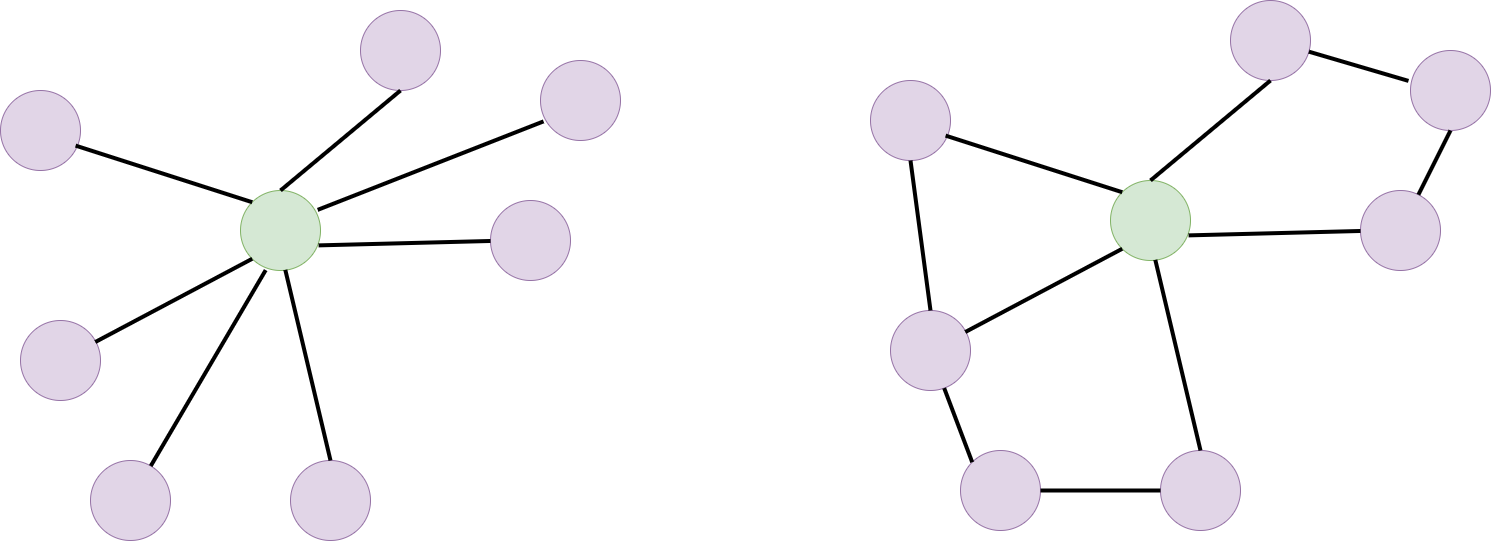

The graph on the left is for the simplified case where the target node(green) is connected to all the text embeddings(purple) directly. The graph on the right is for the neighbors case where the nodes closest to each other(top k) are connected.

In [5]:
class GraphDataset(torch_geometric.data.InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, cond='max', graph_type='simple', path = directory+"*", k = 11):
        self.graph_type = graph_type
        if os.path.exists('data_' + cond):
          self.img_emb = np.load('data_' + cond +'/img_emb.npy')
          self.cap_emb = np.load('data_' + cond +'/cap_emb.npy')
          self.kNN = np.load('data_' + cond +'/kNN.npy')
        else:
            os.mkdir('data_' + cond)
            self.img_emb = []
            self.cap_emb = []
            for file in tqdm.tqdm(glob.glob(path)):
                image_emb = np.load(file)[0]
                caption_emb = np.load(file)[1:]
                self.img_emb.append(image_emb)
                if cond == 'max':
                    self.cap_emb.append(caption_emb[np.argmax(np.dot(image_emb,caption_emb.T)/(np.linalg.norm(image_emb)*np.linalg.norm(caption_emb,axis=1)))])
                elif cond =='avg':
                    sim_array = scipy.special.softmax(np.dot(image_emb,caption_emb.T)/(np.linalg.norm(image_emb)*np.linalg.norm(caption_emb,axis=1)))
                    self.cap_emb.append(np.sum(sim_array[:, None] * caption_emb, axis = 0))



            self.img_emb = np.array(self.img_emb)
            self.cap_emb = np.array(self.cap_emb)

            kNN = []
            img_emb = torch.from_numpy(self.img_emb).float().cuda()
            for emb in tqdm.tqdm(img_emb):
                distance = torch.nn.functional.cosine_similarity(emb.unsqueeze(0), img_emb)
                k_neigh = distance.topk(k, largest=True)
                kNN.append((k_neigh[0][1:].cpu().numpy(),k_neigh[1][1:].cpu().numpy()))

            self.kNN = np.array(kNN)

            np.save('data_' + cond +'/kNN.npy', self.kNN)
            np.save('data_' + cond +'/img_emb.npy', self.img_emb)
            np.save('data_' + cond +'/cap_emb.npy', self.cap_emb)

            
        super(GraphDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []

        for i in tqdm.tqdm(range(len(self.img_emb))):
            data = self.build_graph(i)
            data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def build_graph(self, idx):
        img_emb = torch.from_numpy(self.img_emb[self.kNN[idx][1].astype(np.int32), :])
        cap_emb = torch.from_numpy(self.cap_emb[self.kNN[idx][1].astype(np.int32), :])

        if self.graph_type == 'simple':
            edge_index = torch.tensor([np.concatenate([np.zeros(len(self.kNN[idx][0])),np.arange(1, len(self.kNN[idx][0])+1)]),np.concatenate([np.arange(1, len(self.kNN[idx][0])+1) ,np.zeros(len(self.kNN[idx][0]))])],dtype=torch.long)
            edge_weights = torch.tensor(self.kNN[idx][0])
            edge_weights = torch.cat([edge_weights, edge_weights])

        elif self.graph_type == 'neighbors':

            img_emb = torch.cat([torch.tensor(self.img_emb[idx][None, :]), img_emb])
            adj_dict = {}
            for idx, emb in enumerate(img_emb):
                dist = torch.nn.functional.cosine_similarity(emb.unsqueeze(0), img_emb)
                k_neigh = dist.topk(4, largest=True)
                for i in range(1,4):
                    if str(idx)+'_'+str(k_neigh[1][i].item()) not in adj_dict:
                        adj_dict[str(idx)+'_'+str(k_neigh[1][i].item())] = k_neigh[0][i].item()
                        adj_dict[str(k_neigh[1][i].item())+'_'+str(idx)] = k_neigh[0][i].item()

            edges = torch.tensor([[int(key.split('_')[0]), int(key.split('_')[1]), adj_dict[key]] for key in adj_dict],dtype=torch.double).T
            edge_index = edges[:2]
            edge_weights = torch.tensor(edges[2].clone().detach(),dtype=torch.double)
            
            
        return torch_geometric.data.Data(x=torch.cat([torch.from_numpy(self.img_emb[idx][None, :]), cap_emb]), edge_index=edge_index, edge_attr=edge_weights, y=torch.from_numpy(self.cap_emb[idx]))

In [10]:
batch_size = 32
k = 10
graph_dataset = GraphDataset(root='.', cond='max', graph_type='simple')
graph_dataloader = torch_geometric.loader.DataLoader(graph_dataset, batch_size=batch_size, shuffle=True)

Processing...


  0%|          | 0/82783 [00:00<?, ?it/s]

C:\Users\anand\AppData\Local\Temp\ipykernel_20064\2847396819.py:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  edge_index = torch.tensor([np.concatenate([np.zeros(len(self.kNN[idx][0])),np.arange(1, len(self.kNN[idx][0])+1)]),np.concatenate([np.arange(1, len(self.kNN[idx][0])+1) ,np.zeros(len(self.kNN[idx][0]))])],dtype=torch.long)
Done!


In [11]:
class GraphConvolution(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GraphConvolution, self).__init__()

        self.in_channels = in_channels
        self.hidden_channels = hidden_channels

        self.conv1 = torch_geometric.nn.GCNConv(in_channels, hidden_channels)
        self.conv2 = torch_geometric.nn.GCNConv(hidden_channels, in_channels)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x.to(torch.float32), edge_index, edge_attr)
        return x
    
graphNet = GraphConvolution(768, 4*768).cuda()

In [14]:
criterion = nn.CosineEmbeddingLoss()
graph_optimizer = torch.optim.Adam(graphNet.parameters(), lr=0.0001)

In [15]:
graphNet.train()
for epoch in range(100):
    for i, data in enumerate(graph_dataloader):
        data = data.to('cuda')
        graph_optimizer.zero_grad()
        output = graphNet(data.x, data.edge_index.to(torch.long), data.edge_attr)
        loss = criterion(output.reshape(-1, k + 1, 768)[:,0,:], data.y.reshape(-1, 768), torch.ones(data.y.reshape(-1, 768).size(0)).cuda())
        loss.backward()
        graph_optimizer.step()


    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

torch.save(net.state_dict(), 'knn_max_gcn.pt')

Epoch: 1, Loss: 0.1818321306175076
Epoch: 2, Loss: 0.14019335458956692
Epoch: 3, Loss: 0.1587418611959883
Epoch: 4, Loss: 0.15058275760516718
Epoch: 5, Loss: 0.166902608978833
Epoch: 6, Loss: 0.1521851216683451
Epoch: 7, Loss: 0.16235608529278592
Epoch: 8, Loss: 0.15298734718178728


KeyboardInterrupt: 

## Cross Attention Transformer

![alt text](image.png)

In [34]:
print(glob.glob(directory+"*")[-1])

dataset/train_emb\COCO_train2014_000000581921.npy


In [27]:
def positional_encoding(max_len, d_model):
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1).float()
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, q, k, v):
        batch_size = q.size(0)
        scores = torch.einsum("bhqd,bhkd->bhqk", q, k) / np.sqrt(self.d_k)
        attention = torch.nn.functional.softmax(scores, dim=2)
        return torch.einsum("bhqv,bhvd->bhqd", attention, v)

    def split_heads(self, x, batch_size):
        return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    def group_heads(self, x, batch_size):
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)

    def forward(self, q, k, v):
        batch_size = q.size(0)
        q, k, v = [l(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2) for l, x in zip(self.linear_layers, (q, k, v))]
        x = self.scaled_dot_product_attention(q, k, v)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.output_linear(x)


class SelfAttentionBlock(nn.Module):
    def __init__(self, d_model, num_heads):
        super(SelfAttentionBlock, self).__init__()
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.linear1 = nn.Linear(d_model, 4 * d_model)
        self.dropout = nn.Dropout(0.1)
        self.linear2 = nn.Linear(4 * d_model, d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + self.multi_head_attention(x, x, x)
        x_1 = self.layer_norm1(x)
        x = self.linear2(self.dropout(torch.nn.functional.relu(self.linear1(x_1))))
        x = x + self.dropout(x_1)
        x = self.layer_norm2(x)
        return x
    
class CrossAttentionBlock(nn.Module):
    def __init__(self, d_model, num_heads):
        super(CrossAttentionBlock, self).__init__()
        self.multi_head_self_attention = MultiHeadAttention(d_model, num_heads)
        self.multi_head_cross_attention = MultiHeadAttention(d_model, num_heads)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.linear1 = nn.Linear(d_model, 4 * d_model)
        self.dropout = nn.Dropout(0.1)
        self.linear2 = nn.Linear(4 * d_model, d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)

    def forward(self, x, y):
        x = x + self.multi_head_self_attention(x, x, x)
        x = x + self.multi_head_cross_attention(x, y, y)
        x_1 = self.layer_norm1(x)
        x = self.linear2(self.dropout(torch.nn.functional.relu(self.linear1(x_1))))
        x = x + self.dropout(x_1)
        x = self.layer_norm2(x)
        return x

class CrossAttentionTransformer(nn.Module):
    def __init__(self, d_model, num_heads, num_layers):
        super(CrossAttentionTransformer, self).__init__()
        self.self_attention_blocks = nn.ModuleList([SelfAttentionBlock(d_model, num_heads) for _ in range(num_layers)])
        self.cross_attention_blocks = nn.ModuleList([CrossAttentionBlock(d_model, num_heads) for _ in range(num_layers)])
        self.learnable_embedding = nn.Parameter(torch.zeros((1,d_model)))

    def forward(self, y):
        x = self.learnable_embedding.repeat(y.size(0), 1, 1)
        pe = positional_encoding(y.size(1), y.size(2)).cuda()
        y = y + pe[None, :, :]
        for block in self.self_attention_blocks:
            y = block(y)
        for block in self.cross_attention_blocks:
            x = block(x, y)
        return x 


class SelfAttentionTransformer(nn.Module):
    def __init__(self, d_model, num_heads, num_layers):
        super(SelfAttentionTransformer, self).__init__()
        self.self_attention_blocks = nn.ModuleList([SelfAttentionBlock(d_model, num_heads) for _ in range(num_layers)])

    def forward(self, y):
        pe = positional_encoding(y.size(1), y.size(2)).cuda()
        y = y + pe[None, :, :]
        for block in self.self_attention_blocks:
            y = block(y)
        return y

transformerNet = CrossAttentionTransformer(768, 4, 4).cuda()
selfTransformerNet = SelfAttentionTransformer(768, 4, 4).cuda()

In [30]:
criterion = nn.CosineEmbeddingLoss()
transformer_optimizer = torch.optim.Adam(transformerNet.parameters(), lr=0.0001)
self_transformer_optimizer = torch.optim.Adam(selfTransformerNet.parameters(), lr=0.0001)

In [22]:
transformerNet.train()
for epoch in range(100):
    for i, (img_emb, cap_emb, knn, cap_emb_knn) in enumerate(dataloader):
        batch_size = img_emb.size()[0]
        img_emb = img_emb.cuda().reshape((-1,1,768))
        cap_emb = cap_emb.cuda()
        knn = knn.cuda()
        cap_emb_knn = cap_emb_knn.cuda()

        transformer_optimizer.zero_grad()
        output = transformerNet(torch.cat([img_emb, cap_emb_knn], dim=1))
        loss = criterion(output.squeeze(1), cap_emb, torch.ones(batch_size).cuda())
        loss.backward()
        transformer_optimizer.step()


    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')

torch.save(transformerNet.state_dict(), 'knn_max_transformer.pt')


Epoch: 1, Loss: 0.4250
Epoch: 2, Loss: 0.4249
Epoch: 3, Loss: 0.4247
Epoch: 4, Loss: 0.4299
Epoch: 5, Loss: 0.4367
Epoch: 6, Loss: 0.4223


KeyboardInterrupt: 

In [31]:
selfTransformerNet.train()
for epoch in range(100):
    for i, (img_emb, cap_emb, knn, cap_emb_knn) in enumerate(dataloader):
        batch_size = img_emb.size()[0]
        img_emb = img_emb.cuda().reshape((-1,1,768))
        cap_emb = cap_emb.cuda()
        knn = knn.cuda()
        cap_emb_knn = cap_emb_knn.cuda()

        self_transformer_optimizer.zero_grad()
        output = selfTransformerNet(torch.cat([img_emb, cap_emb_knn], dim=1))
        loss = criterion(output[:,0,:], cap_emb, torch.ones(batch_size).cuda())
        loss.backward()
        self_transformer_optimizer.step()


    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')

torch.save(transformerNet.state_dict(), 'knn_max_transformer.pt')

Epoch: 1, Loss: 0.1973
Epoch: 2, Loss: 0.1907
Epoch: 3, Loss: 0.1758
Epoch: 4, Loss: 0.1702
Epoch: 5, Loss: 0.1676
Epoch: 6, Loss: 0.1581
Epoch: 7, Loss: 0.1685
Epoch: 8, Loss: 0.1640
Epoch: 9, Loss: 0.1680
Epoch: 10, Loss: 0.1633
Epoch: 11, Loss: 0.1474
Epoch: 12, Loss: 0.1639
Epoch: 13, Loss: 0.1530
Epoch: 14, Loss: 0.1554
Epoch: 15, Loss: 0.1469
Epoch: 16, Loss: 0.1406
Epoch: 17, Loss: 0.1321
Epoch: 18, Loss: 0.1329


KeyboardInterrupt: 

# Decoding and Evaluation

In [7]:
import open_clip
import numpy as np
import torch
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import json

In [ ]:
model, _, transform = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)

tokenizer = open_clip.get_tokenizer('coca_ViT-L-14')

In [ ]:
model.generate

In [ ]:
def get_decoded_text(image_path, embedding, model, transform):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0)

    with torch.no_grad(), torch.cuda.amp.autocast():
        text = model.generate(img, image_embs=embedding)
    
    text = open_clip.decode(text[0]).split("<end_of_text>")[0].replace("<start_of_text>", "")
    return text

In [8]:
annotation_file = 'annotations_trainval2014/annotations/captions_val2014.json'
results_file = 'results.json'
f = open(annotation_file)
data = json.load(f)

In [9]:
dict_filename = {}
for image in data['images']:
  dict_filename[image['file_name']] = image['id']

In [ ]:
#json
dict_list = []
root = "val2014/val2014/"
for img_path in glob.glob(root + "*"):
    image_name = img_path.split('/')[-1]
    embedding = val_results[image_name]

    text = get_decoded_text(root + image_name, embedding, model, transform)

    dict_list.append({ "image_id": dict_filename[image_name], "caption": text})

with open(results_file, 'w') as f:
    json.dump(dict_list, f)

In [ ]:
#calculate coco
# create coco object and coco_result object
coco = COCO(annotation_file)
coco_result = coco.loadRes(results_file)

# create coco_eval object by taking coco and coco_result
coco_eval = COCOEvalCap(coco, coco_result)

# evaluate on a subset of images by setting
# coco_eval.params['image_id'] = coco_result.getImgIds()
# please remove this line when evaluating the full validation set
coco_eval.params['image_id'] = coco_result.getImgIds()

# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
coco_eval.evaluate()

# print output evaluation scores
for metric, score in coco_eval.eval.items():
    print(f'{metric}: {score:.3f}')